# Challenge: Factors that affect life expectancy

In this challenge, you'll work with the Life Expectancy dataset from Kaggle. The data is collected from the websites of the World Health Organisation (WHO) and World Bank (WB). The dataset contains annual variables for many of the countries in the world which are divided into several broad categories: immunization related factors, mortality factors, economical factors, and social factors.

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks. Moreover, you can also submit a kernel to the Kaggle containing your solutions.

<b> Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.</b>

1) First, load the dataset.

2) Detect the problems with the data such as missing values and outliers. 
    - Are there any nonsense values that seem to be stemmed from the data collection? 
    - For the missing values, discuss which technique would be the most suitable one in filling out these values.    
    - Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to 
      deal with them.

3) Explore the data using univariate and multivariate exploration techniques. 
    - You should pay special attention to your target variable. 
    - In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

4) In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. 
    - More concretely, you may discard some variables that are very correlated with the other ones or the variables 
      that you think irrelevant with the life expectancy.

5) Summarize your findings using effective visualization.

In [1]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import seaborn as sns; sns.set(color_codes=True)
from sqlalchemy import create_engine
import warnings
import sklearn
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [2]:
#Import dataset from postgres sql server

#defines the logon credentials
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

#opens the connection
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(postgres_user, postgres_pw, postgres_host,
    postgres_port, postgres_db))

#queries the schema
expectancy_df = pd.read_sql_query('select * from lifeexpectancy', con=engine)

#closes the connection
engine.dispose()

### 2) Detect the problems with the data such as missing values and outliers and perform data cleaning exercises

In [3]:
#begin with exploration of the data; understand what we have
expectancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

In [4]:
expectancy_df.isnull().sum()/expectancy_df.isnull().count()

Country                            0.000000
Year                               0.000000
Status                             0.000000
Life expectancy                    0.003404
Adult Mortality                    0.003404
infant deaths                      0.000000
Alcohol                            0.066031
percentage expenditure             0.000000
Hepatitis B                        0.188223
Measles                            0.000000
 BMI                               0.011572
under-five deaths                  0.000000
Polio                              0.006467
Total expenditure                  0.076923
Diphtheria                         0.006467
 HIV/AIDS                          0.000000
GDP                                0.152485
Population                         0.221920
 thinness  1-19 years              0.011572
 thinness 5-9 years                0.011572
Income composition of resources    0.056841
Schooling                          0.055480
dtype: float64

In [5]:
#strip any leading or trailing white spaces
expectancy_df.columns=expectancy_df.columns.str.strip()

In [6]:
#Replace missing values using .mean() for categories whose values will differ by country: Expenditure, 
#Life Expectancy, Adult Mortality, Income, Schooling, Hep B & Alcohol.  Use the average for these features
#as the variability over the 15 years would make this a safe calculation

names=expectancy_df.columns[3:]

for name in names:
    expectancy_df["{}".format(name)]= expectancy_df.groupby(['Country'])["{}".format(name)]\
        .transform(lambda x : x.fillna(x.mean()))

In [7]:
#Replace missing values using .mean() for categories whose values will differ by country & year: 
#GDP, Population, thiness. Use the average for these features
#as the variability over the 15 years would make this a safe calculation
names2=expectancy_df.columns[16:]

for name in names2:
    expectancy_df["{}".format(name)]= expectancy_df.groupby(['Country','Year'])["{}".format(name)]\
        .transform(lambda x : x.fillna(x.mean()))

In [8]:
#Replace remainging missing values using interpolation for categories whose values 
#will differ by country & year: GDP, Population, thiness.
names2=expectancy_df.columns[16:]

for name in names2:    
    expectancy_df.groupby(['Country']).apply(lambda group: group.interpolate(method='nearest'))

In [9]:
expectancy_df.dropna(subset=['Population', 'GDP', 'Hepatitis B', 'BMI'], inplace=True)

In [10]:
#Drop all the discovered -inf values 
expectancy_df.replace([np.inf,-np.inf],np.nan, inplace=True)

In [11]:
expectancy_df.dropna(inplace=True, axis=0, how='any')

In [12]:
#Check % of missing values 
expectancy_df.isnull().sum()/expectancy_df.isnull().count()

Country                            0.0
Year                               0.0
Status                             0.0
Life expectancy                    0.0
Adult Mortality                    0.0
infant deaths                      0.0
Alcohol                            0.0
percentage expenditure             0.0
Hepatitis B                        0.0
Measles                            0.0
BMI                                0.0
under-five deaths                  0.0
Polio                              0.0
Total expenditure                  0.0
Diphtheria                         0.0
HIV/AIDS                           0.0
GDP                                0.0
Population                         0.0
thinness  1-19 years               0.0
thinness 5-9 years                 0.0
Income composition of resources    0.0
Schooling                          0.0
dtype: float64

In [13]:
expectancy_clean=expectancy_df

In [14]:
expectancy_clean.describe(include='all')

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2128,2128.000000,2128,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,...,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2.128000e+03,2128.000000,2128.000000,2128.000000,2128.000000
unique,133,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Guatemala,NaN,Developing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,16,NaN,1824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.500000,NaN,68.139709,174.300282,35.902726,4.436893,640.072009,77.272061,2657.467105,...,80.572006,5.888411,80.699919,2.173637,5408.637801,1.340066e+07,5.107895,5.177538,0.607481,11.691823
std,NaN,4.610856,NaN,9.610700,129.759274,136.224732,3.962858,1710.798798,25.260036,11912.236064,...,24.170053,2.256161,24.174256,5.827273,11374.230200,6.315714e+07,4.711951,4.805378,0.203404,3.203263
min,NaN,2000.000000,NaN,36.300000,1.000000,0.000000,0.010000,0.000000,2.000000,0.000000,...,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,NaN,2003.750000,NaN,62.000000,76.000000,1.000000,0.827500,19.883256,68.000000,0.000000,...,75.000000,4.367500,76.000000,0.100000,395.911290,1.989615e+05,1.600000,1.600000,0.476750,9.800000
50%,NaN,2007.500000,NaN,69.950000,152.000000,4.000000,3.735000,83.677991,87.000000,20.000000,...,91.000000,5.800000,91.000000,0.100000,1351.177885,1.433672e+06,3.400000,3.400000,0.649500,11.900000
75%,NaN,2011.250000,NaN,74.800000,241.250000,24.000000,7.162500,431.365149,95.000000,459.250000,...,96.000000,7.333000,96.000000,1.300000,4494.285047,7.785482e+06,7.525000,7.600000,0.747000,13.800000


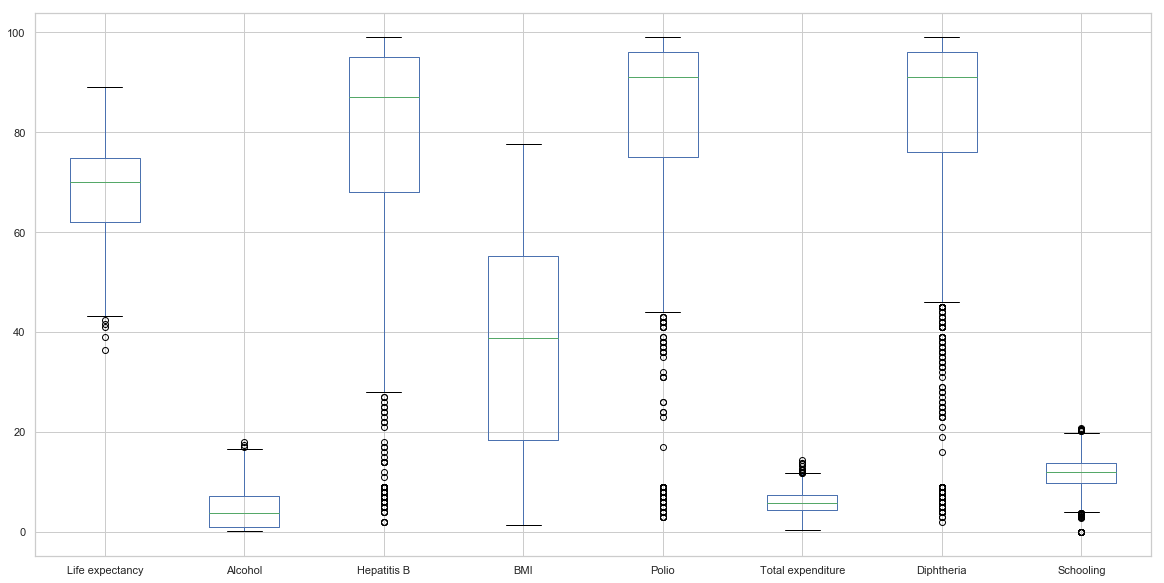

In [15]:
#Check for outliers using boxplots

plt.figure(figsize=(20,10))

boxplot=expectancy_clean.boxplot(column=['Life expectancy', 'Alcohol','Hepatitis B', 'BMI', 'Polio','Total expenditure', 
      'Diphtheria', 'Schooling'])

In [16]:
#Use IQR to statisically determine outliers
numeric_cols=expectancy_clean.select_dtypes(include=[np.number]).columns
#expectancy_clean[numeric_cols].apply(zscore)


q75, q25 = np.percentile(expectancy_clean[numeric_cols], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((expectancy_clean[numeric_cols] > max_val) 
                      | (expectancy_clean[numeric_cols] < min_val))[0]))
    ))

The score threshold is: 1.0
Number of outliers is: 8512
The score threshold is: 1.5
Number of outliers is: 8096
The score threshold is: 2.0
Number of outliers is: 7729
The score threshold is: 2.5
Number of outliers is: 7492
The score threshold is: 3.0
Number of outliers is: 7230
The score threshold is: 3.5
Number of outliers is: 7076
The score threshold is: 4.0
Number of outliers is: 6891
The score threshold is: 4.5
Number of outliers is: 6772


In [17]:
# # now we take the log of the video views and calculate
# # the quartiles accordingly.
# numeric_cols=expectancy_clean.select_dtypes(include=[np.number]).columns

# q75, q25 = np.percentile(np.log(expectancy_clean[numeric_cols]), [75 ,25])
# iqr = q75 - q25

# for threshold in np.arange(1,5,0.5):
#     min_val = q25 - (iqr*threshold)
#     max_val = q75 + (iqr*threshold)
#     print("The score threshold is: {}".format(threshold))
#     print("Number of outliers is: {}".format(
#         len((np.where((np.log(expectancy_clean[numeric_cols]) > max_val) 
#                       | (np.log(expectancy_clean[numeric_cols]) < min_val))[0]))
#     ))

In [18]:
# names=expectancy_clean.columns[3:]
# fthis=expectancy_clean
#education_df["winsorized_{}".format(name)] = winsorize(education_df["{}".format(name)], (0.1, 0.1))
# names=expectancy_df.columns[2:]

# for name in names:
#      expectancy_clean["{}".format(name)]= winsorize(expectancy_clean["{}".format(name)], (0.05, 0.05))

In [19]:
def using_mstats(s):
    return winsorize(s, limits=[0.05, 0.05])

expectancy_clean = expectancy_clean.apply(using_mstats, axis=0)
expectancy_clean.quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0.00,2000.00,49.80,13.00,0.0,0.0100,0.000000,9.0,0.00,5.100,0.00,9.0,1.9300,9.0,0.1,56.424987,8977.00,0.600,0.5,0.29000,5.8
0.05,2000.00,49.80,13.00,0.0,0.0100,0.000000,9.0,0.00,5.135,0.00,9.0,1.9300,9.0,0.1,56.616229,9134.15,0.600,0.5,0.29035,5.8
0.25,2003.75,62.00,76.00,1.0,0.8275,19.883256,68.0,0.00,18.400,1.00,75.0,4.3675,76.0,0.1,395.911290,198961.50,1.600,1.6,0.47675,9.8
0.50,2007.50,69.95,152.00,4.0,3.7350,83.677991,87.0,20.00,38.850,4.00,91.0,5.8000,91.0,0.1,1351.177885,1433672.00,3.400,3.4,0.64950,11.9
0.75,2011.25,74.80,241.25,24.0,7.1625,431.365149,95.0,459.25,55.200,34.25,96.0,7.3330,96.0,1.3,4494.285047,7785482.50,7.525,7.6,0.74700,13.8
0.95,2015.00,81.50,426.00,117.3,12.0065,3660.812573,99.0,11560.75,63.500,161.00,99.0,9.5665,99.0,11.2,28907.815340,49174356.30,14.665,14.8,0.88000,16.4
1.00,2015.00,81.50,426.00,118.0,12.0100,3665.089703,99.0,11699.00,63.500,161.00,99.0,9.5700,99.0,11.2,28951.155560,49175848.00,14.700,14.8,0.88000,16.4


In [20]:
# #Use IQR to statisically determine outliers
# numeric_cols=expectancy_clean.select_dtypes(include=[np.number]).columns
# #expectancy_clean[numeric_cols].apply(zscore)


# q75, q25 = np.percentile(expectancy_clean[numeric_cols], [75 ,25])
# iqr = q75 - q25

# for threshold in np.arange(1,5,0.5):
#     min_val = q25 - (iqr*threshold)
#     max_val = q75 + (iqr*threshold)
#     print("The score threshold is: {}".format(threshold))
#     print("Number of outliers is: {}".format(
#         len((np.where((expectancy_clean[numeric_cols] > max_val) 
#                       | (expectancy_clean[numeric_cols] < min_val))[0]))
#     ))

In [21]:
from pandas.api.types import is_numeric_dtype

def remove_outlier(expectancy_clean):
    df = expectancy_clean.copy()
    low = .05
    high = .95
    quant_df = df.quantile([low, high])
    for name in list(df.columns):
        if is_numeric_dtype(df[name]):
          df[name] = winsorize(df[name], (low, high))
    return df

test= remove_outlier(expectancy_clean)

test.describe().T


,count,mean,std,min,25%,50%,75%,max
Year,2128.0,2000.000000,0.000000e+00,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
Life expectancy,2128.0,49.800000,7.107097e-15,49.800000,49.800000,49.800000,49.800000,49.800000
Adult Mortality,2128.0,13.000000,0.000000e+00,13.000000,13.000000,13.000000,13.000000,13.000000
infant deaths,2128.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
Alcohol,2128.0,0.010000,1.735131e-18,0.010000,0.010000,0.010000,0.010000,0.010000
percentage expenditure,2128.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
Hepatitis B,2128.0,9.000000,0.000000e+00,9.000000,9.000000,9.000000,9.000000,9.000000
Measles,2128.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
BMI,2128.0,5.100000,8.883872e-16,5.100000,5.100000,5.100000,5.100000,5.100000
under-five deaths,2128.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000


In [22]:
expectancy_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,2128.0,2.007500e+03,4.610856e+00,2000.000000,2003.750000,2.007500e+03,2.011250e+03,2.015000e+03
Life expectancy,2128.0,6.817768e+01,9.053229e+00,49.800000,62.000000,6.995000e+01,7.480000e+01,8.150000e+01
Adult Mortality,2128.0,1.694789e+02,1.154064e+02,13.000000,76.000000,1.520000e+02,2.412500e+02,4.260000e+02
infant deaths,2128.0,1.908929e+01,3.082682e+01,0.000000,1.000000,4.000000e+00,2.400000e+01,1.180000e+02
Alcohol,2128.0,4.379255e+00,3.832077e+00,0.010000,0.827500,3.735000e+00,7.162500e+00,1.201000e+01
percentage expenditure,2128.0,4.695949e+02,9.042529e+02,0.000000,19.883256,8.367799e+01,4.313651e+02,3.665090e+03
Hepatitis B,2128.0,7.735759e+01,2.502171e+01,9.000000,68.000000,8.700000e+01,9.500000e+01,9.900000e+01
Measles,2128.0,1.207004e+03,2.926497e+03,0.000000,0.000000,2.000000e+01,4.592500e+02,1.169900e+04
BMI,2128.0,3.656560e+01,1.933745e+01,5.100000,18.400000,3.885000e+01,5.520000e+01,6.350000e+01
under-five deaths,2128.0,2.692669e+01,4.369444e+01,0.000000,1.000000,4.000000e+00,3.425000e+01,1.610000e+02


In [23]:
# #Use IQR to statisically determine outliers
# numeric_cols=test.select_dtypes(include=[np.number]).columns
# #expectancy_clean[numeric_cols].apply(zscore)


# q75, q25 = np.percentile(test[numeric_cols], [75 ,25])
# iqr = q75 - q25

# for threshold in np.arange(1,5,0.5):
#     min_val = q25 - (iqr*threshold)
#     max_val = q75 + (iqr*threshold)
#     print("The score threshold is: {}".format(threshold))
#     print("Number of outliers is: {}".format(
#         len((np.where((test[numeric_cols] > max_val) 
#                       | (test[numeric_cols] < min_val))[0]))
#     ))

In [24]:
q75, q25 = np.percentile(expectancy_clean[numeric_cols], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    print('Min value: ', min_val)
    max_val = q75 + (iqr*threshold)
    print('Max value: ', max_val)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((expectancy_clean[numeric_cols] > max_val) 
                      | (expectancy_clean[numeric_cols] < min_val))[0]))
    ))

Min value:  -90.74000000000001
Max value:  192.37
The score threshold is: 1.0
Number of outliers is: 8352
Min value:  -137.925
Max value:  239.555
The score threshold is: 1.5
Number of outliers is: 7967
Min value:  -185.11
Max value:  286.74
The score threshold is: 2.0
Number of outliers is: 7620
Min value:  -232.29500000000002
Max value:  333.925
The score threshold is: 2.5
Number of outliers is: 7400
Min value:  -279.48
Max value:  381.11
The score threshold is: 3.0
Number of outliers is: 7153
Min value:  -326.665
Max value:  428.295
The score threshold is: 3.5
Number of outliers is: 6907
Min value:  -373.85
Max value:  475.48
The score threshold is: 4.0
Number of outliers is: 6776
Min value:  -421.035
Max value:  522.665
The score threshold is: 4.5
Number of outliers is: 6692


### 3) Explore the data using univariate and multivariate exploration techniques.

- You should pay special attention to your target variable. 
- In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

In [26]:
#begin with exploration of the data; understand what we have
expectancy_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2128 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2128 non-null object
Year                               2128 non-null int64
Status                             2128 non-null object
Life expectancy                    2128 non-null float64
Adult Mortality                    2128 non-null float64
infant deaths                      2128 non-null int64
Alcohol                            2128 non-null float64
percentage expenditure             2128 non-null float64
Hepatitis B                        2128 non-null float64
Measles                            2128 non-null int64
BMI                                2128 non-null float64
under-five deaths                  2128 non-null int64
Polio                              2128 non-null float64
Total expenditure                  2128 non-null float64
Diphtheria                         2128 non-null float64
HIV/AIDS                           2128 non-null

Text(0.5, 1.0, 'histogram of thinness 5-9 years')

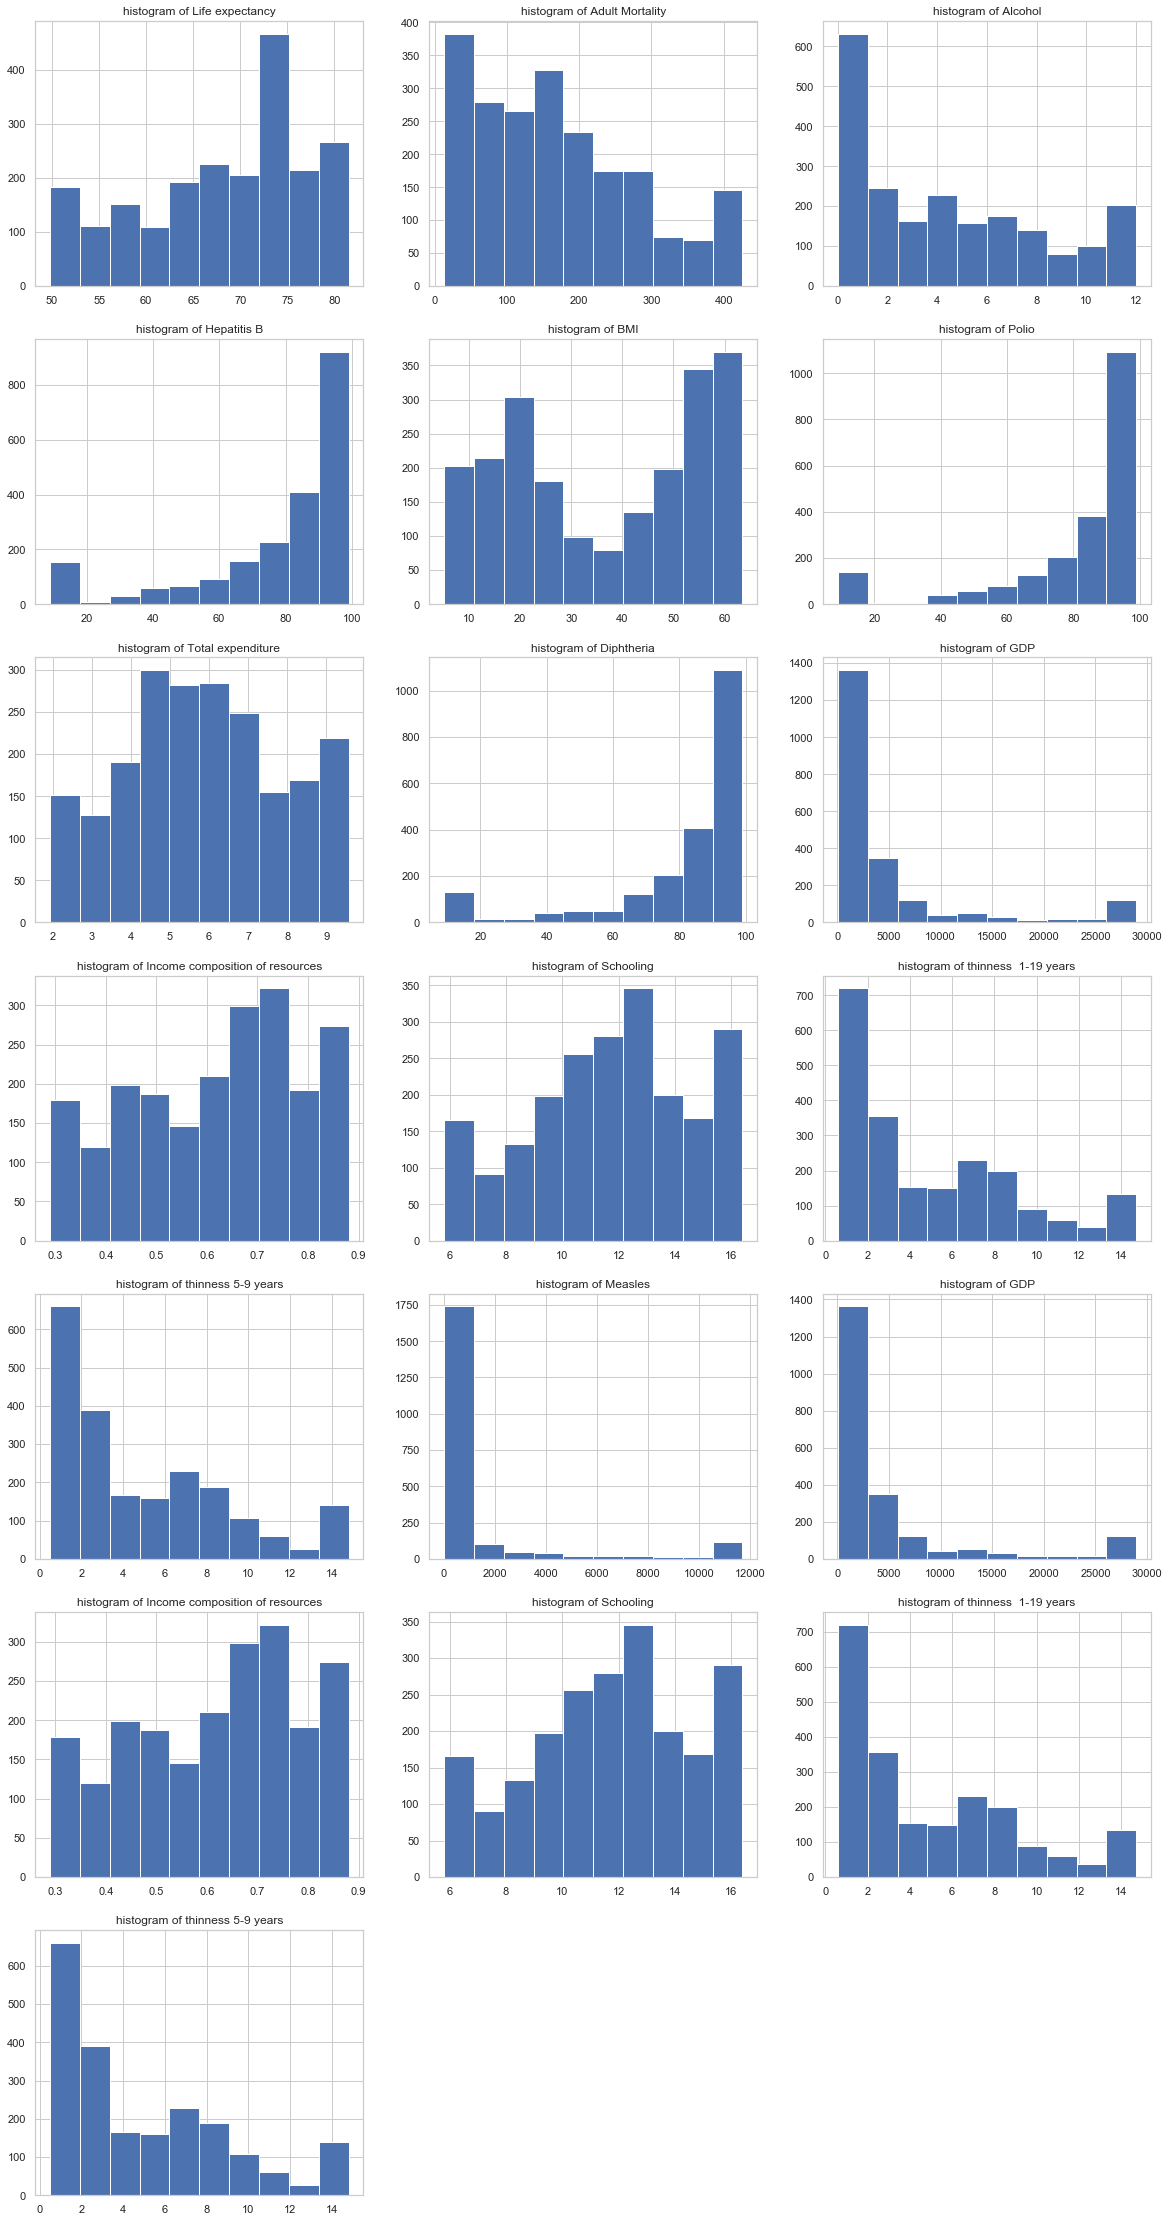

In [27]:
#Visually look at the distribution of the numercal variables (19)

plt.figure(figsize=(20,40))

# histograms of the data
plt.subplot(7, 3, 1)
plt.hist(expectancy_clean['Life expectancy'])
plt.title("histogram of Life expectancy")

plt.subplot(7, 3, 2)
plt.hist(expectancy_clean['Adult Mortality'])
plt.title("histogram of Adult Mortality")

plt.subplot(7, 3, 3)
plt.hist(expectancy_clean['Alcohol'])
plt.title("histogram of Alcohol")

plt.subplot(7, 3, 4)
plt.hist(expectancy_clean['Hepatitis B'])
plt.title("histogram of Hepatitis B")

plt.subplot(7, 3, 5)
plt.hist(expectancy_clean['BMI'])
plt.title("histogram of BMI")

plt.subplot(7, 3, 6)
plt.hist(expectancy_clean['Polio'])
plt.title("histogram of Polio")

plt.subplot(7, 3, 7)
plt.hist(expectancy_clean['Total expenditure'])
plt.title("histogram of Total expenditure")

plt.subplot(7, 3, 8)
plt.hist(expectancy_clean['Diphtheria'])
plt.title("histogram of Diphtheria")

plt.subplot(7, 3, 9)
plt.hist(expectancy_clean['GDP'])
plt.title("histogram of GDP")

plt.subplot(7, 3, 10)
plt.hist(expectancy_clean['Income composition of resources'])
plt.title("histogram of Income composition of resources")

plt.subplot(7, 3, 11)
plt.hist(expectancy_clean['Schooling'])
plt.title("histogram of Schooling")

plt.subplot(7, 3, 12)
plt.hist(expectancy_clean['thinness  1-19 years'])
plt.title("histogram of thinness  1-19 years")

plt.subplot(7, 3, 13)
plt.hist(expectancy_clean['thinness 5-9 years'])
plt.title("histogram of thinness 5-9 years")

plt.subplot(7, 3, 14)
plt.hist(expectancy_clean['Measles'])
plt.title("histogram of Measles")

plt.subplot(7, 3, 15)
plt.hist(expectancy_clean['GDP'])
plt.title("histogram of GDP")

plt.subplot(7, 3, 16)
plt.hist(expectancy_clean['Income composition of resources'])
plt.title("histogram of Income composition of resources")

plt.subplot(7, 3, 17)
plt.hist(expectancy_clean['Schooling'])
plt.title("histogram of Schooling")

plt.subplot(7, 3, 18)
plt.hist(expectancy_clean['thinness  1-19 years'])
plt.title("histogram of thinness  1-19 years")

plt.subplot(7, 3, 19)
plt.hist(expectancy_clean['thinness 5-9 years'])
plt.title("histogram of thinness 5-9 years")

Text(0.5, 1.0, 'Correlation Matrix Life Expectancy')

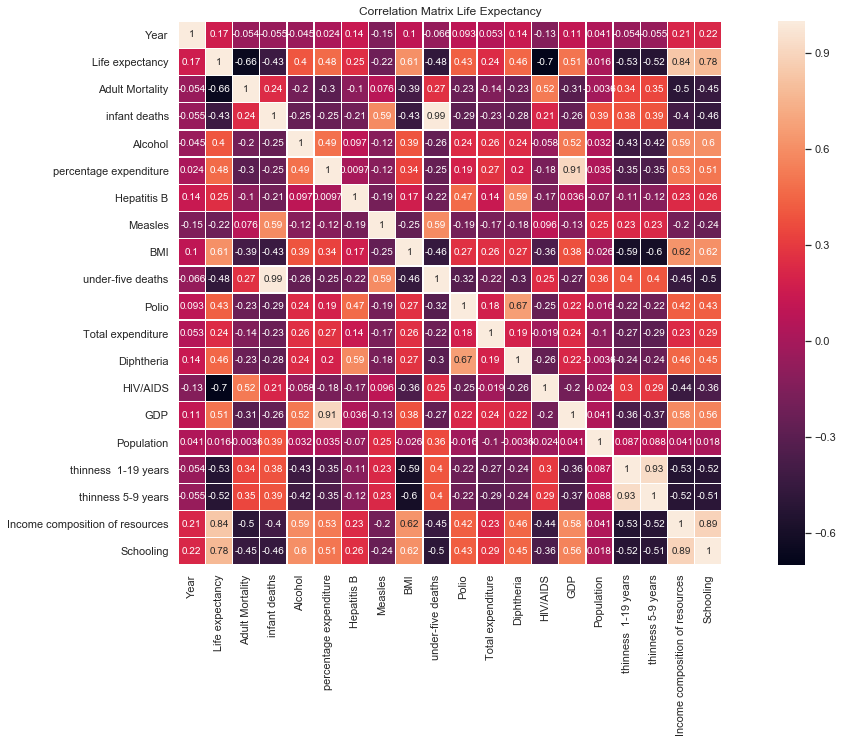

In [28]:
#Plot a heatmap to see the correlations

numeric_cols=expectancy_clean.select_dtypes(include=[np.number]).columns
corrmat_expectancy=expectancy_clean[numeric_cols].corr()


plt.figure(figsize=(20,10))

sns.heatmap(corrmat_expectancy, square=True, annot=True, linewidths=.5)
plt.title("Correlation Matrix Life Expectancy")

The features with the greatest positive correlations (>.5) are: BMI, GDP, Income Composition and Schooling.  The features with the greatest negative correlations (>-.25) are: thiness (2), HIV/AIDS, and Adult Mortality.

### 4) In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase.

- More concretely, you may discard some variables that are very correlated with the other ones or the variables 
  that you think irrelevant with the life expectancy.


For the target variable "Life Expectancy" I would select the following variables for building a model:

1. Income Composition (corr .73)
2. Schooling (corr .75)
3. BMI
4. PCA on remaining 15 variables

However, since is challenge is more focused on PCA, I will run PCA on the following combination of variables as
they have the greatest correlations amongst each other and highest against target variable:
1. Infant Deaths + Death under 5
2. Income Composition + Schooling
3. Diptheria & Polio
4. GDP + % Expenditure

In [29]:
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import datasets
import pylab as pl

#Select the 18 features to calculate optimal number of features
#numeric_cols=expectancy_clean.select_dtypes(include=[np.number]).columns
df = expectancy_clean.drop(expectancy_clean.columns[[0, 1, 2]], axis=1) 

#Normalize the data so that all variables have a mean of 0 and standard deviation of 1.
X = StandardScaler().fit_transform(df)

#Calculate covariance matrix
pca=PCA(n_components=19, svd_solver='full')
pca.fit(X)


PCA(copy=True, iterated_power='auto', n_components=19, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [30]:
#Calculate Eigenvectors & Eigenvalues

#calculate variance ratios
variance = pca.explained_variance_ratio_    
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var 

array([ 38.7,  50.1,  59.5,  67. ,  73.1,  77.6,  81.5,  85. ,  87.7,
        90.2,  92.6,  94.8,  96.6,  98.1,  98.7,  99.2,  99.6, 100. ,
       100. ])

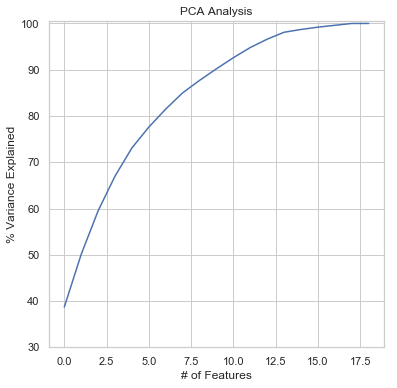

In [31]:
#Plot PCA output to see eigenvectors over eigenvalues and determine optimal number of features to select

plt.figure(figsize=(6,6))

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')


plt.plot(var)


In [50]:
#Now run PCA for the features I pre-selected

df1 = expectancy_clean[['infant deaths', 'under-five deaths', 'Diphtheria', 'Polio','GDP', 'percentage expenditure']]
# df2 = expectancy_clean[[]]
# df3 = expectancy_clean[[]]
# df4 = expectancy_clean[['GDP', 'percentage expenditure']]

#Normalize the data so that all variables have a mean of 0 and standard deviation of 1.
a = StandardScaler().fit_transform(df1)
# b = StandardScaler().fit_transform(df2)
# c = StandardScaler().fit_transform(df3)
# d = StandardScaler().fit_transform(df4)

#Calculate covariance matrices
pca1=PCA(n_components=2)
pca1.fit(a)

# pca2=PCA(n_components=1)
# pca2.fit(b)

# pca3=PCA(n_components=1)
# pca3.fit(c)

# pca4=PCA(n_components=1)
# pca4.fit(d)


PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [51]:
print('PCA1= ', pca1.explained_variance_ratio_)
# print('PCA2= ', pca2.explained_variance_ratio_)
# print('PCA3= ', pca3.explained_variance_ratio_)
# print('PCA4= ', pca4.explained_variance_ratio_)

PCA1=  [0.48124264 0.24497379]


In [52]:
T=pca1.transform(df1)

In [53]:
df1.shape

(2128, 6)

In [54]:
T.shape

(2128, 2)

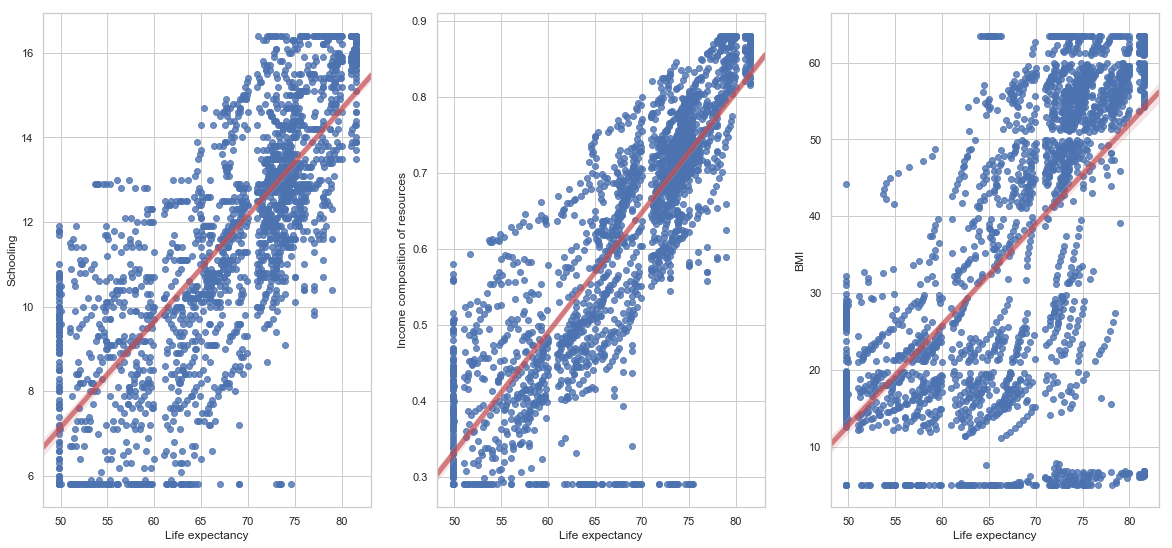

In [49]:
#Plot the original (clean) dataset to show the relationship between target variable "Life Expectancy"
#and the 3 features with the highest correlations.
#This visualization is using the normal data.

plt.figure(figsize=(20,20))

plt.subplot(2,3,1)
sns.regplot(x=expectancy_clean['Life expectancy'], y=expectancy_clean['Schooling'],
            line_kws={'color': 'r', 'alpha':0.7, 'lw':5})

plt.subplot(2,3,2)
sns.regplot(x=expectancy_clean['Life expectancy'], y=expectancy_clean['Income composition of resources'],
            line_kws={'color': 'r', 'alpha':0.7, 'lw':5})

plt.subplot(2,3,3)
sns.regplot(x=expectancy_clean['Life expectancy'], y=expectancy_clean['BMI'],
            line_kws={'color': 'r', 'alpha':0.7, 'lw':5})

plt.show()

In [ ]:
#Now to visualize the target variable with the three other features and the 2 PCA components
#first need to create a new df concantenating the selected features

expectancy=pd.concat()

In [ ]:

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()